### Amazon Sentiment Analysis

In [250]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from nltk.corpus import stopwords
import re
import os
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.model_selection import train_test_split

FAT_BAR = '='*50

#####  import & rename columns

In [139]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw.columns = ['review','sentiment']

amzn_raw.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


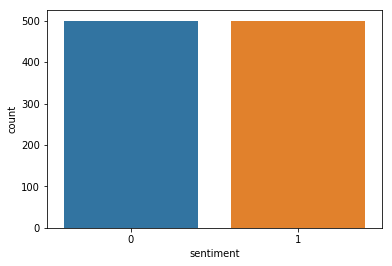

In [140]:
sns.countplot(amzn_raw.sentiment)

plt.show()

##### Clean and process for evaluation

In [141]:
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import bigrams

#stopwords = set(stopwords.words('english'))

STEMMER = SnowballStemmer("english", ignore_stopwords=True)

def preprocess(text: pd.Series) -> pd.Series:
    text = text.apply(gensim.utils.simple_preprocess, min_len=3)
    sw = set(stopwords.words('english')) 
    text = text.apply(lambda s: [w for w in s if w not in sw])
    #text = text.apply(lambda s: [STEMMER.stem(w) for w in s])
    #text = text.apply(lambda s: ['_'.join(x) for x in nltk.bigrams(s)] + s)

    return text

##### Create a column of cleaned words

In [142]:
amzn_clean = amzn_raw

amzn_clean['review'] = preprocess(amzn_clean['review']); amzn_clean.head()

,review,sentiment
0,"[way, plug, unless, converter]",0
1,"[good, case, excellent, value]",1
2,"[great, jawbone]",1
3,"[tied, charger, conversations, lasting, minute...",0
4,"[mic, great]",1


##### Run Named Entity Recognition to see what words/categories are in reviews

split into positive and negative reviews using dict comprehension

In [143]:
split_reviews = {
    val: amzn_clean[amzn_clean.sentiment==val].reset_index()
    for val in amzn_clean.sentiment.unique()
}

In [144]:
split_reviews[0].head()

,index,review,sentiment
0,0,"[way, plug, unless, converter]",0
1,3,"[tied, charger, conversations, lasting, minute...",0
2,5,"[jiggle, plug, get, line, right, get, decent, ...",0
3,6,"[several, dozen, several, hundred, contacts, i...",0
4,8,"[needless, say, wasted, money]",0


##### Get most common word in each review

In [145]:
from collections import Counter

def most_common(words):
    counter = Counter(words[0])
    [counter.update(i) for i in words[1:]]

    return counter.most_common()

##### Most common negative

In [171]:
negative_most_common = most_common(split_reviews[0].review.tolist()) 

neg_df = pd.DataFrame(negative_most_common).rename(columns={0:'word',1:'frequency'})
top_50_neg = neg_df.loc[0:50]
top_50_neg.head()

,word,frequency
0,phone,80
1,work,25
2,battery,24
3,product,22
4,use,20


##### Most common positive

In [172]:
positive_most_common = most_common(split_reviews[1].review.tolist()) 

pos_df = pd.DataFrame(positive_most_common).rename(columns={0:'word',1:'frequency'})
top_50_pos = pos_df.loc[0:50]
top_50_pos.head()

,word,frequency
0,great,94
1,phone,88
2,good,65
3,works,46
4,well,35


In [80]:
#sns.distplot(x=0,y=1,data=positive_most_common)

#### Identify Keywords

Reset original reviews

In [193]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw.columns = ['review','sentiment']

amzn_raw.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [194]:
#neg_df.word.tolist()

In [195]:
kw_list = neg_df.word.loc[0:5].tolist() + pos_df.word.loc[0:5].tolist()

In [196]:
for key in kw_list:
    amzn_raw.loc[:,str(key)] =  amzn_raw.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [197]:
amzn_raw.head()

,review,sentiment,phone,work,battery,product,use,ear,great,good,works,well
0,So there is no way for me to plug it in here i...,0,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,False,False,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,False,False,False,False,False,False,False,False,False,False


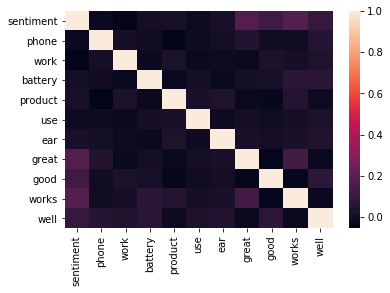

In [198]:
sns.heatmap(amzn_raw.corr())

plt.show()

##### Fit the data

In [199]:
data = amzn_raw[kw_list]
target = amzn_raw['sentiment']

In [200]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 410


##### Calculate the confusion matrix

In [201]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[466,  34],
       [376, 124]])

In [202]:
1-(target != y_pred).sum()/len(target)

0.5900000000000001

So on the first pass we got an accuracy of 59% - this was with only 5 keywords from the positive and negative list. Next we will up it to 20

### Run #2

In [210]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw_2 = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw_2.columns = ['review','sentiment']

kw_list_2 = neg_df.word.loc[0:20].tolist() + pos_df.word.loc[0:20].tolist()

for key in kw_list_2:
    amzn_raw_2[str(key)] = amzn_raw_2.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [260]:
data = amzn_raw_2[kw_list_2]
target = amzn_raw_2['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
                                                data, 
                                                target, 
                                                test_size=0.2, 
                                                random_state=20)

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print(FAT_BAR)
print('accuracy')
print(1-(target != y_pred).sum()/len(target))
print(FAT_BAR)
print('confusion matrix')
print(confusion_matrix(target, y_pred))
print(FAT_BAR)
print('cross val')
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

Number of mislabeled points out of a total 1000 points : 345
accuracy
0.655
confusion matrix
[[440  60]
 [285 215]]
cross val
With 20% Holdout: 0.63
Testing on Sample: 0.655


### Run #3

In [215]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw_3 = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw_3.columns = ['review','sentiment']

kw_list_3 = neg_df.word.loc[0:50].tolist() + pos_df.word.loc[0:50].tolist()

for key in kw_list_3:
    amzn_raw_3[str(key)] = amzn_raw_3.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [259]:
data = amzn_raw_3[kw_list_3]
target = amzn_raw_3['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
                                                data, 
                                                target, 
                                                test_size=0.2, 
                                                random_state=20)

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print(FAT_BAR)
print('accuracy')
print(1-(target != y_pred).sum()/len(target))
print(FAT_BAR)
print('confusion matrix')
print(confusion_matrix(target, y_pred))
print(FAT_BAR)
print('cross val')
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

Number of mislabeled points out of a total 1000 points : 320
accuracy
0.6799999999999999
confusion matrix
[[416  84]
 [236 264]]
cross val
With 20% Holdout: 0.63
Testing on Sample: 0.68


### Run #4

In [246]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw_4 = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw_4.columns = ['review','sentiment']

kw_list_4 = neg_df.word.loc[0:350].tolist() + pos_df.word.loc[0:350].tolist()

In [247]:
for key in kw_list_4:
    amzn_raw_4[str(key)] = amzn_raw_4.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    
data = amzn_raw_4[kw_list_4]
target = amzn_raw_4['sentiment']

In [258]:
X_train, X_test, y_train, y_test = train_test_split(
                                                data, 
                                                target, 
                                                test_size=0.2, 
                                                random_state=20)

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print(FAT_BAR)
print('accuracy')
print(1-(target != y_pred).sum()/len(target))
print(FAT_BAR)
print('confusion matrix')
print(confusion_matrix(target, y_pred))
print(FAT_BAR)
print('cross val')
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

Number of mislabeled points out of a total 1000 points : 211
accuracy
0.789
confusion matrix
[[439  61]
 [150 350]]
cross val
With 20% Holdout: 0.675
Testing on Sample: 0.789


### Run #5

In [286]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw_5 = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw_5.columns = ['review','sentiment']

kw_list_5 = neg_df.word.loc[0:365].tolist() + pos_df.word.loc[0:365].tolist()

In [287]:
for key in kw_list_5:
    amzn_raw_5[str(key)] = amzn_raw_5.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    
data = amzn_raw_5[kw_list_5]
target = amzn_raw_5['sentiment']

In [288]:
X_train, X_test, y_train, y_test = train_test_split(
                                                data, 
                                                target, 
                                                test_size=0.2, 
                                                random_state=20)

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print(FAT_BAR)
print('accuracy')
print(1-(target != y_pred).sum()/len(target))
print(FAT_BAR)
print('confusion matrix')
print(confusion_matrix(target, y_pred))
print(FAT_BAR)
print('cross val')
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

Number of mislabeled points out of a total 1000 points : 212
accuracy
0.788
confusion matrix
[[438  62]
 [150 350]]
cross val
With 20% Holdout: 0.675
Testing on Sample: 0.788


### Run #6

In [326]:
data_path = ('./data/amazon_cells_labelled.txt')
amzn_raw_6 = pd.read_csv(data_path, delimiter= '\t', header=None)
amzn_raw_6.columns = ['review','sentiment']

kw_list_6 = neg_df.word.loc[0:350].tolist() + pos_df.word.loc[0:350].tolist()

In [327]:
amzn_raw_6['review_length'] = [len(j) for i,j in amzn_raw_5.review.iteritems()]

In [328]:
for key in kw_list_6:
    amzn_raw_6[str(key)] = amzn_raw_6.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    
data = amzn_raw_6[kw_list_6]
target = amzn_raw_6['sentiment']

In [329]:
X_train, X_test, y_train, y_test = train_test_split(
                                                data, 
                                                target, 
                                                test_size=0.2, 
                                                random_state=20)

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print(FAT_BAR)
print('accuracy')
print(1-(target != y_pred).sum()/len(target))
print(FAT_BAR)
print('confusion matrix')
print(confusion_matrix(target, y_pred))
print(FAT_BAR)
print('cross val')
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

Number of mislabeled points out of a total 1000 points : 211
accuracy
0.789
confusion matrix
[[439  61]
 [150 350]]
cross val
With 20% Holdout: 0.675
Testing on Sample: 0.789


### Summary

Did 6 runs when I went above 700 columns I peaked at ~79 percent. I added in another feature that counted the number of words in a review and added that mix, but that did not improve the prediction accuracy. So it looks like without further feature engineering it will hold at about 80%.